## 필요 라이브러리 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/cakd7/3차프로젝트_dl_1025_1128/5팀(윤정준, 최애림, 진청아, 이정현a)/코드'

/content/drive/.shortcut-targets-by-id/1SSMjIaDcwniFaLUaXBuU9Ry1IjYbaq-j/cakd7/3차프로젝트_dl_1025_1128/5팀(윤정준, 최애림, 진청아, 이정현a)/코드


In [ ]:
!apt update && apt install -y openslide-tools
!pip install ipython-autotime
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,307 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:14 http://ppa.launc

In [ ]:
from tensorflow.keras.utils import array_to_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from openslide import open_slide, __library_version__ as openslide_version
%load_ext autotime
import tensorflow as tf

time: 293 µs (started: 2022-12-03 08:11:58 +00:00)


## 경로 지정

In [ ]:
#원본 이미지
train_images = glob("./train_imgs/*.png")
len(train_images)

1000

time: 7.39 s (started: 2022-12-03 08:11:58 +00:00)


In [ ]:
# 전체 학습 이미지 경로 지정
## 베이스 경로
base_dir = './train_imgs/'

## 파일이름 리스트
slide_files = os.listdir(base_dir)

## 전체경로 리스트
slide_paths = [base_dir + slide_file for slide_file in slide_files]
slide_paths[:2]

['./train_imgs/BC_01_0001.png', './train_imgs/BC_01_0002.png']

time: 11.2 ms (started: 2022-11-29 06:33:13 +00:00)


## 패치화된 배열 데이터 불러오기

In [ ]:
slide_patches_all = np.load('./array/1125_32_32_50/1125_real_train_1_50(50).npy', allow_pickle = True)
slide_patches_all.shape

(50,)

time: 17.1 s (started: 2022-11-29 05:05:36 +00:00)


In [ ]:
slide_patches_size = np.load('./array/1125_32_32_50/1125_real_train_size_1_50(50).npy', allow_pickle = True)
slide_patches_size[:5]

array([[ 93, 191],
       [ 83, 186],
       [ 99, 186],
       [ 87, 181],
       [ 90, 165]], dtype=int32)

time: 990 ms (started: 2022-11-29 05:05:53 +00:00)


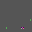

time: 4.13 ms (started: 2022-11-29 05:09:23 +00:00)


In [ ]:
array_to_img(slide_patches_all[0][0])

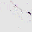

time: 8.55 ms (started: 2022-11-29 05:15:40 +00:00)


In [ ]:
array_to_img(slide_patches_all[2][1050])

## 배경/조직 구분 임곗값 지정을 위한 TEST

In [ ]:
st_d_d = []
for i in slide_patches_all[0]:
  if i.std() > 5:
    st_d_d.append(i.std()-100)
  else:
    st_d_d.append(i.std())

time: 1.34 s (started: 2022-11-25 10:01:59 +00:00)


In [ ]:
np.array(st_d_d).argmin()

2672

time: 5.43 ms (started: 2022-11-25 10:02:21 +00:00)


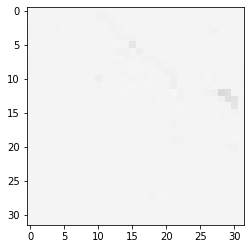

time: 132 ms (started: 2022-11-29 05:15:52 +00:00)


In [ ]:
# from google.colab.patches import cv2_imshow
import cv2

img = cv2.cvtColor(slide_patches_all[2][1050], cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 학습된 모델 불러오기

In [ ]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 2.35 ms (started: 2022-12-03 08:29:19 +00:00)


In [ ]:
# 모델 불러오기
model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/1124_tumor_best_model.hdf5')

time: 6 s (started: 2022-11-28 01:30:33 +00:00)


In [ ]:
# 전체 마스킹된 하나의 이미지를 담을 빈 리스트 생성 
all_mask_label = []

# 500개 이미지에 대해 마스킹
for i in range(50):
    print(f'*** 이미지{i+1}번째')
    # 이미지 한 개당 사이즈 측정
    size_col, size_row = slide_patches_size[i]

    # 출력을 위한 종양, 비종양 개수 객체 만들기
    tumor = 0
    non_tumor = 0

    # 하나의 이미지에 해당하는 패치들의 마스킹 라벨 담을 빈 리스트 생성
    mask_label = []

    # 이미지 한 개당 여러 패치 마스킹
    for patch in slide_patches_all[i]:

        # 흰 배경은 예측 하지 말고 바로 append        
        if patch.std() < 10:
          non_tumor += 1
          mask_label.append(0)
        else:
          # 정규화
          patch = (patch.astype('float32') / 255.) * 2.0 - 1

          # 학습된 모델로 예측
          preds = model.predict(patch[None,:], verbose = 0)
          ## 예측값이 0.5보다 크면 종양
          if preds > 0.5:
              tumor += 1
              mask_label.append(1)

          ## 예측값이 0.5보다 작으면 비종양
          else:
              non_tumor += 1
              mask_label.append(0)

    # 이미지 사이즈에 맞게 배열 조정하고 all_mask_label리스트에 담기
    all_mask_label.append(np.array(mask_label).reshape(size_row, size_col))

    print(f'tumor 개수: {tumor}')
    print(f'non_tumor 개수: {non_tumor}')
    all_mask_label_arr = np.array(all_mask_label)

In [ ]:
import pickle

with open('11125_all_mask_label_arr.pickle', 'wb') as f:
  pickle.dump(all_mask_label_arr, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
for j in range(0, 1000, 50):
  slide_patches_all = np.load(f'./array/1125_32_32_50/1125_real_train_{j+1}_{j+50}(50).npy', allow_pickle = True)

  slide_patches_size = np.load(f'./array/1125_32_32_50/1125_real_train_size_{j+1}_{j+50}(50).npy', allow_pickle = True)

  # 전체 마스킹된 하나의 이미지를 담을 빈 리스트 생성 
  all_mask_label = []

  # 500개 이미지에 대해 마스킹
  for i in range(50):
      print(f'*** 이미지{i+1}번째')
      # 이미지 한 개당 사이즈 측정
      size_col, size_row = slide_patches_size[i]

      # 출력을 위한 종양, 비종양 개수 객체 만들기
      tumor = 0
      non_tumor = 0

      # 하나의 이미지에 해당하는 패치들의 마스킹 라벨 담을 빈 리스트 생성
      mask_label = []

      # 이미지 한 개당 여러 패치 마스킹
      for patch in slide_patches_all[i]:

          # 흰 배경은 예측 하지 말고 바로 append        
          if patch.std() < 10:
            non_tumor += 1
            mask_label.append(0)
          else:
            # 정규화
            patch = (patch.astype('float32') / 255.) * 2.0 - 1

            # 학습된 모델로 예측
            preds = model.predict(patch[None,:], verbose = 0)
            ## 예측값이 0.5보다 크면 종양
            if preds > 0.8:
                tumor += 1
                mask_label.append(1)

            ## 예측값이 0.5보다 작으면 비종양
            else:
                non_tumor += 1
                mask_label.append(0)

      # 이미지 사이즈에 맞게 배열 조정하고 all_mask_label리스트에 담기
      all_mask_label.append(np.array(mask_label).reshape(size_col, size_row))

      print(f'tumor 개수: {tumor}')
      print(f'non_tumor 개수: {non_tumor}')
      all_mask_label_arr = np.array(all_mask_label)
      array_to_img(all_mask_label_arr[i][:,:,None])

  with open(f'pic/11128_all_mask_label_arr_{j+1}_{j+50}(50).pickle', 'wb') as f:
    pickle.dump(all_mask_label_arr, f, pickle.HIGHEST_PROTOCOL)

*** 이미지1번째
tumor 개수: 3595
non_tumor 개수: 15696
*** 이미지2번째
tumor 개수: 1903
non_tumor 개수: 12932
*** 이미지3번째


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


tumor 개수: 1748
non_tumor 개수: 9484
*** 이미지4번째
tumor 개수: 2684
non_tumor 개수: 13551
*** 이미지5번째
tumor 개수: 1655
non_tumor 개수: 14009
*** 이미지6번째
tumor 개수: 1666
non_tumor 개수: 12633
*** 이미지7번째
tumor 개수: 1910
non_tumor 개수: 9770
*** 이미지8번째
tumor 개수: 2495
non_tumor 개수: 11442
*** 이미지9번째
tumor 개수: 2114
non_tumor 개수: 12909
*** 이미지10번째
tumor 개수: 1409
non_tumor 개수: 13006
*** 이미지11번째
tumor 개수: 3586
non_tumor 개수: 14864
*** 이미지12번째
tumor 개수: 1568
non_tumor 개수: 12754
*** 이미지13번째
tumor 개수: 1403
non_tumor 개수: 12037
*** 이미지14번째
tumor 개수: 3702
non_tumor 개수: 13408
*** 이미지15번째
tumor 개수: 1463
non_tumor 개수: 14217
*** 이미지16번째
tumor 개수: 1112
non_tumor 개수: 13730
*** 이미지17번째
tumor 개수: 1899
non_tumor 개수: 15201
*** 이미지18번째
tumor 개수: 1439
non_tumor 개수: 15148
*** 이미지19번째
tumor 개수: 2322
non_tumor 개수: 14222
*** 이미지20번째
tumor 개수: 1820
non_tumor 개수: 14020
*** 이미지21번째
tumor 개수: 1596
non_tumor 개수: 14068
*** 이미지22번째
tumor 개수: 3020
non_tumor 개수: 12524
*** 이미지23번째
tumor 개수: 2549
non_tumor 개수: 11587
*** 이미지24번째
tumor 개수: 2590
non_tu

KeyboardInterrupt: ignored

time: 4h 10min 36s (started: 2022-11-28 01:54:26 +00:00)


In [ ]:
plt.figure(figsize = (50,50))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(all_mask_label_arr[i], cmap = 'gray')

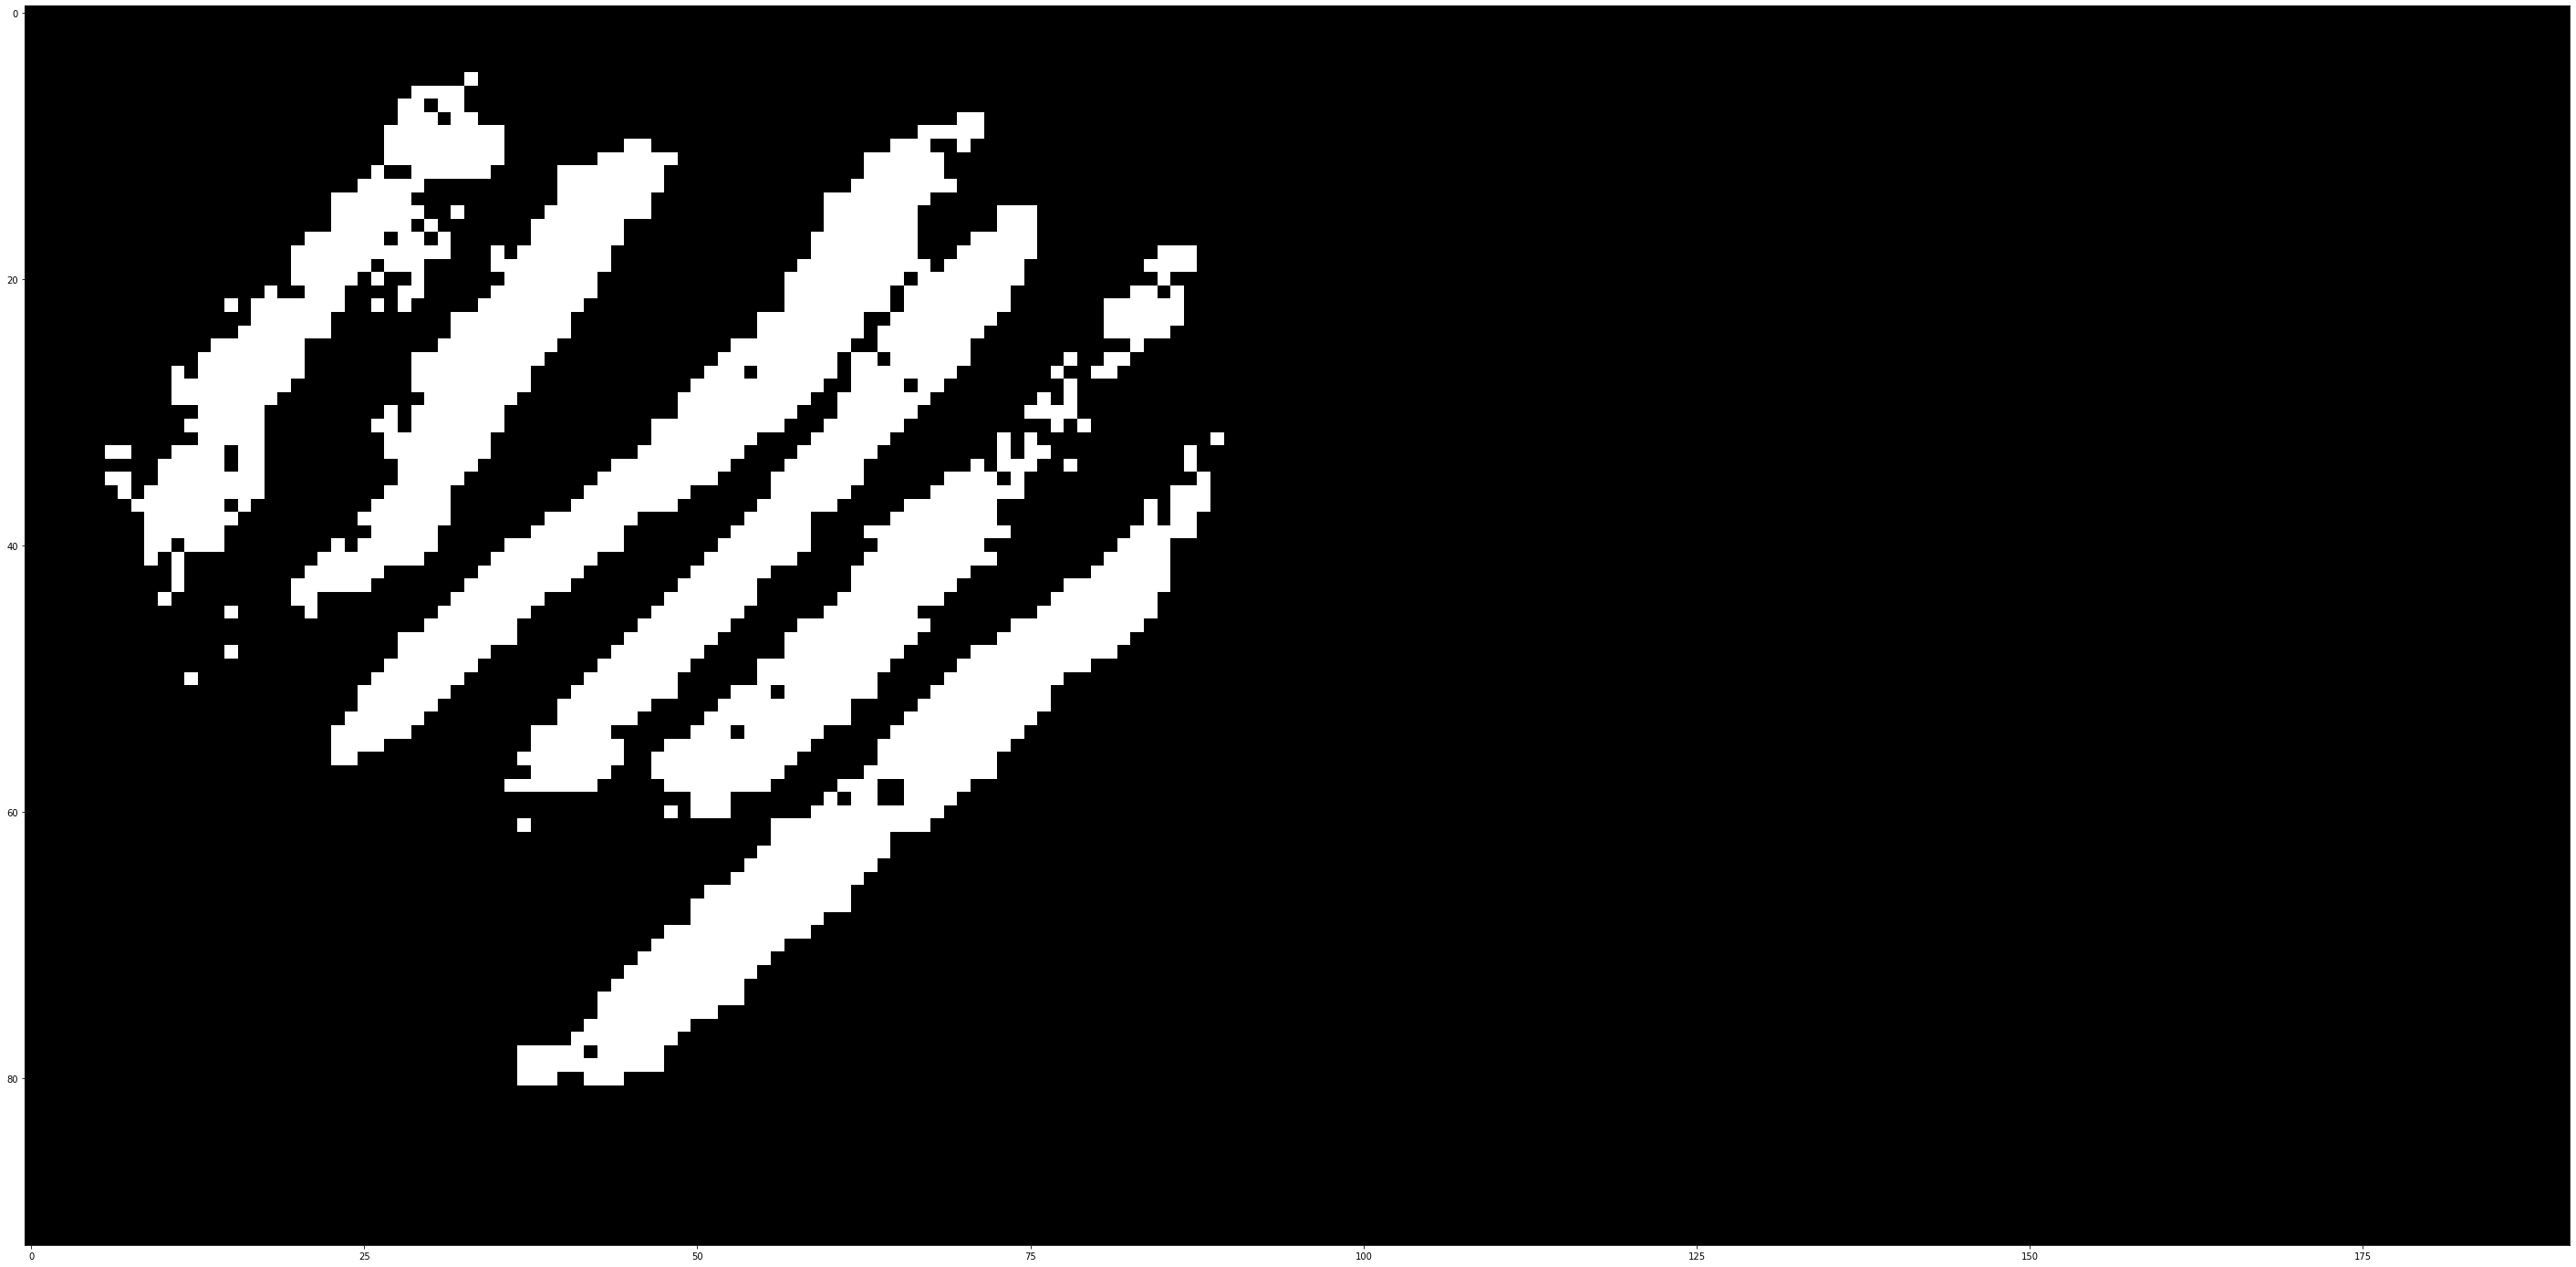

time: 1.38 s (started: 2022-11-25 09:57:29 +00:00)


In [ ]:
plt.figure(figsize = (50,50))
plt.imshow(all_mask_label_arr[0], cmap = 'gray')

## 최종 학습된 모델로 마스킹 예측

In [ ]:
# 모델 불러오기
## 침윤성 vs 비침윤성
model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/best_model.hdf5')

## 종양 vs 비종양 균형
# model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/1124_tumor_best_model.hdf5', custom_objects={'recall_m':recall_m, 'precision_m': precision_m, 'f1_m':f1_m}) 4

## 종양 vs 비종양 불균형
# model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/1124_all_tumor_best_model.hdf5', custom_objects={'recall_m':recall_m, 'precision_m': precision_m, 'f1_m':f1_m})

## 종양 vs 정상 5픽셀 overlap
# model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/1130_all_TumorNormal_best_model.hdf5') 

## 종양 vs 정상 10픽셀 overlap
# model = load_model('./Checkpoints/InceptionV3-Freeze40-UnbalData/1130_all_10픽셀_TumorNormal_best_model.hdf5', custom_objects={'recall_m':recall_m, 'precision_m': precision_m, 'f1_m':f1_m}) 3


time: 3.81 s (started: 2022-12-03 08:50:56 +00:00)


In [ ]:
slide_patches_all.shape

(50,)

time: 3.8 ms (started: 2022-12-03 08:17:44 +00:00)


In [ ]:
for j in range(0, 50, 50):
  # slide_patches_all = np.load(f'./array/1125_32_32_50/1125_real_train_{j+1}_{j+50}(50).npy', allow_pickle = True)

  # slide_patches_size = np.load(f'./array/1125_32_32_50/1125_real_train_size_{j+1}_{j+50}(50).npy', allow_pickle = True)

  # 전체 마스킹된 하나의 이미지를 담을 빈 리스트 생성 
  all_mask_label_1 = []

  # 500개 이미지에 대해 마스킹
  for i in range(13,14):
      print(f'*** 이미지{i+1}번째')
      # 이미지 한 개당 사이즈 측정
      size_col, size_row = slide_patches_size[i]

      # 출력을 위한 종양, 비종양 개수 객체 만들기
      tumor = 0
      non_tumor = 0

      # 하나의 이미지에 해당하는 패치들의 마스킹 라벨 담을 빈 리스트 생성
      mask_label = []

      # 이미지 한 개당 여러 패치 마스킹
      for patch in slide_patches_all[i]:

          # 흰 배경은 예측 하지 말고 바로 append        
          if patch.std() < 10:
            non_tumor += 1
            mask_label.append(0)
          else:
            # 정규화
            patch = (patch.astype('float32') / 255.) * 2.0 - 1

            # 학습된 모델로 예측
            preds = model.predict(patch[None,:], verbose = 0)
            ## 예측값이 0.5보다 크면 종양
            if preds > 0.3:
                tumor += 1
                mask_label.append(1)

            ## 예측값이 0.5보다 작으면 비종양
            else:
                non_tumor += 1
                mask_label.append(0)

      # 이미지 사이즈에 맞게 배열 조정하고 all_mask_label리스트에 담기
      all_mask_label_1.append(np.array(mask_label).reshape(size_col, size_row))

      print(f'tumor 개수: {tumor}')
      print(f'non_tumor 개수: {non_tumor}')
      all_mask_label_arr_1 = np.array(all_mask_label_1)

  # with open(f'pic/11129_cha_mask_label_arr_{13}_(1)_1.pickle', 'wb') as f:
  #   pickle.dump(all_mask_label_arr_1, f, pickle.HIGHEST_PROTOCOL)

*** 이미지14번째
tumor 개수: 42
non_tumor 개수: 11838
time: 1min 51s (started: 2022-12-03 08:55:38 +00:00)


### 종양/비종양 불균형 마스킹 예측

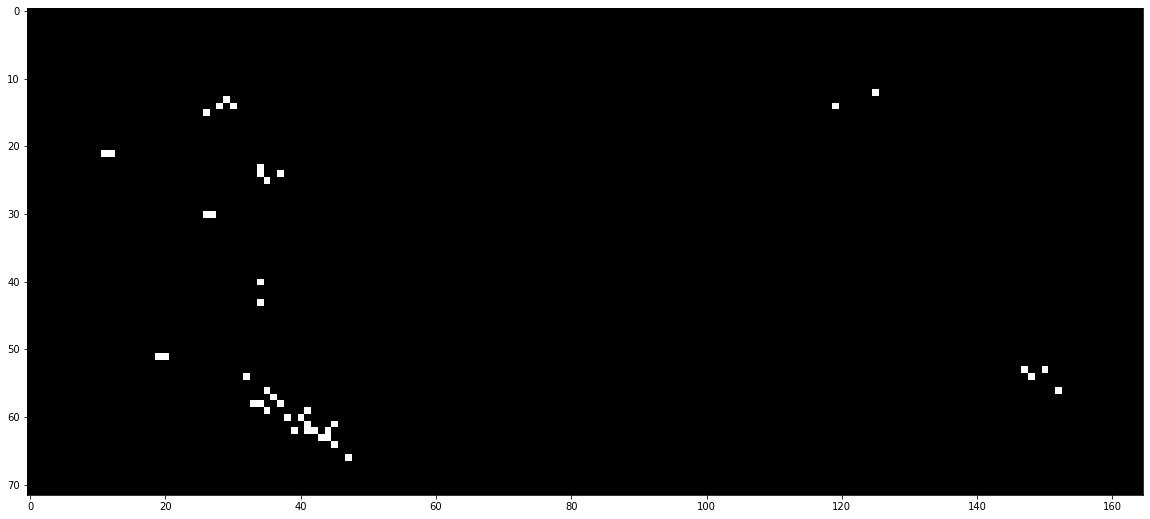

time: 301 ms (started: 2022-12-03 08:57:29 +00:00)


In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))     # 0.5

# array_to_img(test[0][:,:,None])
plt.imshow(all_mask_label_arr_1[0], cmap='gray')

### 종양/정상 5픽셀 overlap 마스킹 예측

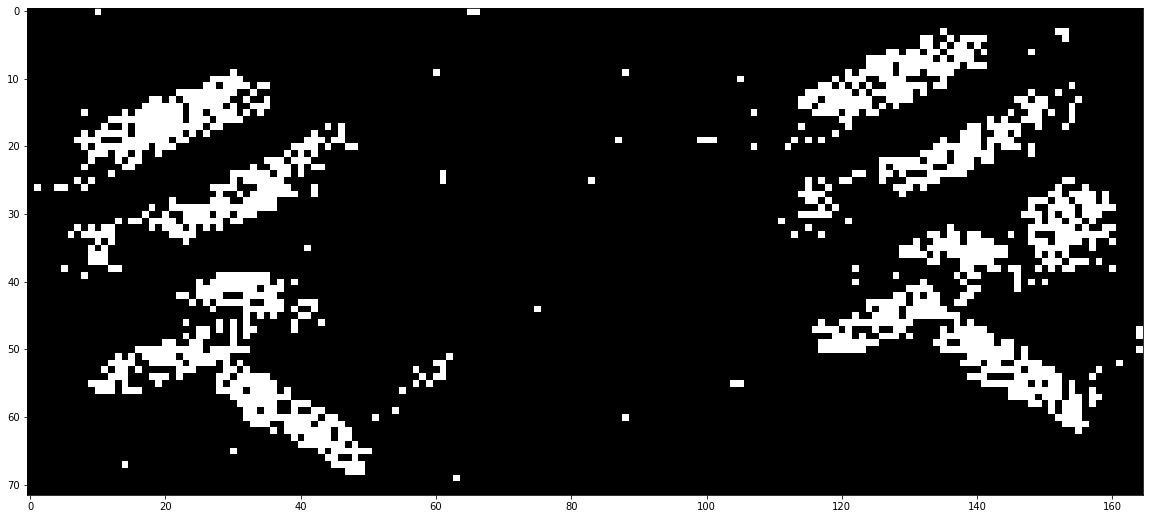

time: 256 ms (started: 2022-12-03 08:27:52 +00:00)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))  # 0.55
# array_to_img(test[0][:,:,None])

plt.imshow(all_mask_label_arr_1[0], cmap='gray')

### 종양/정상 10픽셀 overlap 마스킹 예측

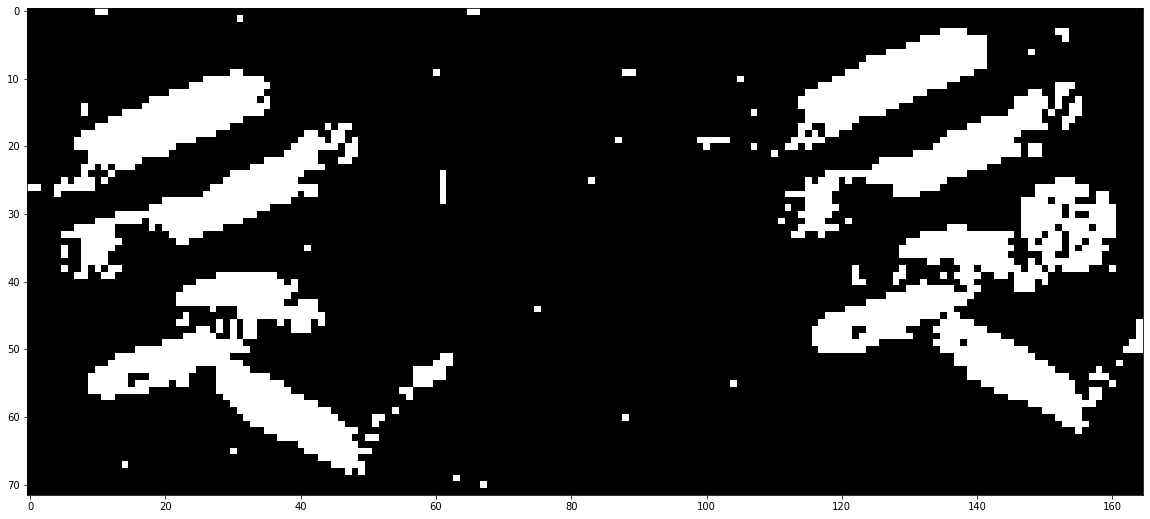

time: 275 ms (started: 2022-12-03 08:38:11 +00:00)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))     # 0.69
# array_to_img(test[0][:,:,None])
# tumor 개수: 1962
# non_tumor 개수: 9918
plt.imshow(all_mask_label_arr_1[0], cmap='gray')

In [ ]:
import pickle

with open(f'./pic/11128_exp_mask_label_arr_1_(1).pickle', 'rb') as f:
            test = pickle.load(f)

time: 1.06 s (started: 2022-11-29 05:17:46 +00:00)
